# Nearest route to urban centrality

Notebook that contains the analysis of shortest path routes for urban centralities and route saturation developed for Guggenheim exposition.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import igraph as ig
import matplotlib.pyplot as plt
from shapely.geometry import MultiLineString, Point, LineString
import random

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgar/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.1-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Urban centralities

### AMG

In [2]:
gdf = gpd.read_file('../data/processed/Centralidades/Centralidades_AMG_2020-2040_UTM_v1.geojson', driver='GeoJSON')
gdf = gdf.to_crs("EPSG:4326")
print(gdf.shape)
gdf.head(1)

(27, 41)


,fid,nombre,clasif,can_rut_tp,cap_rut_tp,dens_pob,pers_ocupa,equipamien,l_tp_masiv,uni_econ,...,auxiliar17,auxiliar18,auxiliar19,auxiliar20,numero,n_centrali,RmvCnt,Tiempo,Cnt_Route,geometry
0,11.0,Centro Tlaquepaque,Centralidad Metropolitana,0.69,0.32,1.0,0.48,0.94,0.5,0.58,...,None,1.0,675392.648633,2.283998e+06,3.0,Centro &Tlaquepaque,2,2040,1,POINT (-103.31079 20.63935)


<AxesSubplot:>

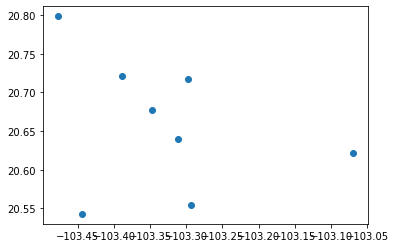

In [3]:
gdf_cnt = gdf[gdf['numero'].isin([1,2,3,6,21,23,24,25])]
cnt_nodes = gdf_cnt.copy()
gdf_cnt.plot()

### ZMM

In [4]:
gdf = gpd.read_file('../data/processed/Centralidades/Centralidades_ZMM_GCS_v1.geojson', driver='GeoJSON')
gdf = gdf.to_crs("EPSG:4326")
print(gdf.shape)
gdf.head(1)

(8, 4)


,nombre,lon,lat,geometry
0,Macroplaza,25.669994,-100.308845,POINT (-100.30885 25.66999)


<AxesSubplot:>

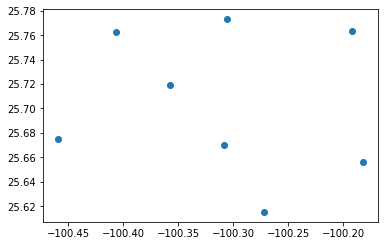

In [5]:
cnt_nodes = gdf.copy()
gdf_cnt = gdf.copy()
gdf_cnt.plot()

## Municipalities

### AMG

In [4]:
amg = {"Guadalajara":{"mpos":["14002", "14039", "14044", "14051", 
                              "14070", "14097", "14098", "14101", 
                              "14120", "14124"],"edo":["14"]}}
df_met = pd.DataFrame(amg)
df_met.head(1)

,Guadalajara
edo,[14]


### ZMM

In [6]:
zmm = {"Monterrey":{"mpos":["19001", "19006", "19009", "19010", 
                            "19012", "19018", "19019", "19021", "19025", 
                            "19026", "19031", "19039", "19041", "19045", "19046", 
                            "19047", "19048", "19049"],"edo":["19"]}}
df_met = pd.DataFrame(zmm)
df_met.head(1)

,Monterrey
edo,[19]


In [7]:
mun_gdf = gpd.GeoDataFrame()

for m in df_met.loc['mpos'][0]:
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
print(mun_gdf.shape)
mun_gdf.head(1)

(18, 5)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,19001,19,001,Abasolo,"POLYGON ((-100.39267 25.98715, -100.39224 25.9..."


<AxesSubplot:>

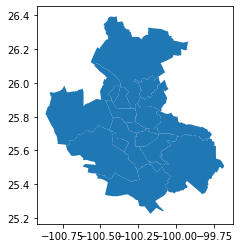

In [8]:
mun_gdf.plot()

In [9]:
mun_gdf = mun_gdf.reset_index().drop(columns='index')
mun_gdf = mun_gdf.to_crs("EPSG:4326")

## Hex-bins

In [10]:
res = 9
hex_gdf = aup.create_hexgrid(mun_gdf, res)

/home/edgar/Repos/Observatorio-ciudades/accesibilidad-urbana/aup/utils.py:335: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = polygon.explode().reset_index(drop=True)


In [13]:
print(hex_gdf.shape)
hex_gdf.head(2)

(61878, 2)


,geometry,hex_id_9
0,"POLYGON ((-100.44817 25.93054, -100.44688 25.9...",8948a2230cfffff
1,"POLYGON ((-100.43216 25.91851, -100.43346 25.9...",8948a2236c7ffff


<AxesSubplot:>

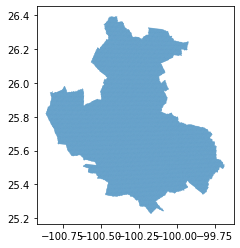

In [12]:
hex_gdf.plot()

## OSMnx

In [14]:
G,nodes,edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [15]:
nodes.set_index('osmid', inplace=True)
print(nodes.shape)
nodes.head(1)

(216260, 4)


,x,y,street_count,geometry
osmid,,,,
269701904,-100.25117,25.731077,3.0,POINT (-100.25117 25.73108)


<AxesSubplot:>

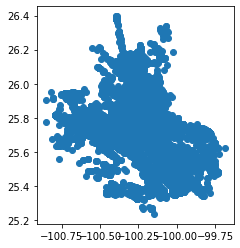

In [16]:
nodes.plot()

In [17]:
print(edges.shape)
edges.head(1)

(548443, 15)


,,,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
u,v,key,,,,,,,,,,,,,,,
344482418,7953829181,0,239617896,True,3,Calle José María Arteaga,tertiary,None,29.604,"LINESTRING (-100.31537 25.68329, -100.31507 25...",None,None,None,None,None,None,None


<AxesSubplot:>

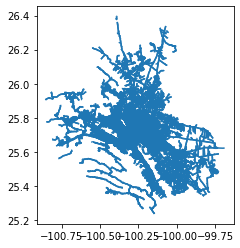

In [18]:
edges.plot()

## Create random centralities

In [34]:
hex_t0 = gpd.read_file(f'../data/processed/hex_route/ZMM_hex_time_t0.geojson', driver='GeoJSON')
hex_t0 = hex_t0.set_crs("EPSG:4326")

hex_nodes_tmp = hex_t0[['hex_id_9','distance','geometry']].loc[hex_t0['distance']>1250].sjoin(nodes)
hex_nodes_tmp = hex_nodes_tmp.groupby('hex_id_9').count()['index_right'].reset_index()
hex_nodes_tmp.rename(columns={'index_right':'count'}, inplace=True)
hex_nodes_tmp.loc[hex_nodes_tmp['count']>2].merge(hex_t0, on='hex_id_9', how='left')['count'].sum()

204352

In [32]:
hex_t0 = gpd.read_file(f'../data/processed/hex_route/ZMM_hex_time_t0.geojson', driver='GeoJSON')
hex_t0 = hex_t0.set_crs("EPSG:4326")

hex_nodes_tmp = hex_t0[['hex_id_9','distance','geometry']].loc[hex_t0['distance']>1250].sjoin(nodes)
hex_nodes_tmp = hex_nodes_tmp.groupby('hex_id_9').count()['index_right'].reset_index()
hex_nodes_tmp.rename(columns={'index_right':'count'}, inplace=True)
hex_nodes_tmp = hex_nodes_tmp.loc[hex_nodes_tmp['count']>2].merge(hex_t0, on='hex_id_9', how='left')
hex_nodes_tmp = gpd.GeoDataFrame(hex_nodes_tmp, geometry='geometry')
hex_nodes_tmp = hex_nodes_tmp.set_crs("EPSG:4326")

nodes_h3 = gpd.sjoin(nodes, hex_nodes_tmp)
print(nodes_h3.shape)
nodes_h3.head(3)

(204352, 9)


,x,y,street_count,geometry,index_right,hex_id_9,count,distance,time_min
osmid,,,,,,,,,
269701904,-100.251170,25.731077,3.0,POINT (-100.25117 25.73108),5032,8948a20e567ffff,26,7946.991,119.204269
1360547151,-100.251918,25.730735,3.0,POINT (-100.25192 25.73073),5032,8948a20e567ffff,26,7946.991,119.204269
1360547179,-100.251488,25.731003,3.0,POINT (-100.25149 25.73100),5032,8948a20e567ffff,26,7946.991,119.204269


In [38]:
num_cnt = 50
choices = [random.choices(list(nodes_h3['hex_id_9'].unique()),k=i) for i in [num_cnt]]

In [39]:
cnt_nodes = gpd.GeoDataFrame()

for i in range(len(choices[0])):
    cnt_nodes = cnt_nodes.append(nodes_h3[nodes_h3['hex_id_9'] == choices[0][i]].sample())
    
gdf_cnt = gdf_cnt.to_crs("EPSG:4326")
cnt_columns = cnt_nodes.columns.to_list()
cnt_nodes = cnt_nodes.append(gdf_cnt)[cnt_columns]

print(cnt_nodes.shape)
cnt_nodes.head(2)

(58, 9)


,x,y,street_count,geometry,index_right,hex_id_9,count,distance,time_min
8732963425,-100.554986,25.709640,3.0,POINT (-100.55499 25.70964),9712.0,8948a2a8a83ffff,10.0,12339.780,185.095775
4154007674,-100.451490,25.984514,3.0,POINT (-100.45149 25.98451),6796.0,8948a221507ffff,18.0,31009.657,465.142529


<AxesSubplot:>

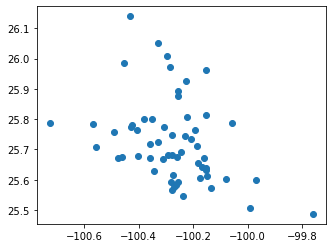

In [40]:
cnt_nodes.plot()

### Save urban centralities

In [41]:
cnt_nodes.to_file(f'../data/processed/hex_route/ZMM_Centralities_t1.geojson', driver='GeoJSON')

## Hex to nodes

In [42]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_cnt = hex_gdf.centroid
hex_cnt = gpd.GeoDataFrame(hex_cnt, geometry=0)
hex_cnt = hex_cnt.to_crs("EPSG:4326")
hex_gdf = hex_gdf.to_crs("EPSG:4326")
print(hex_cnt.shape)
hex_cnt.head(1)

(61878, 1)


,0
0,POINT (-100.44904 25.93235)


<AxesSubplot:>

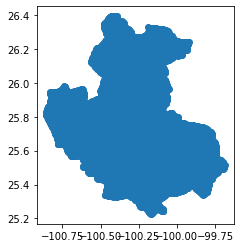

In [43]:
hex_cnt.plot()

In [44]:
hex_nodes = aup.find_nearest(G, nodes, hex_cnt, return_distance=True)
hex_nodes = hex_nodes.sjoin(hex_gdf)
hex_nodes = hex_nodes.rename(columns={0:'geometry'}).drop(columns=['index_right'])
print(hex_nodes.shape)
hex_nodes.head(4)

(61878, 4)


,geometry,osmid,distance_node,hex_id_9
0,POINT (-100.44904 25.93235),8698998124,1977.955531,8948a2230cfffff
1,POINT (-100.43129 25.91670),8699019786,1955.420452,8948a2236c7ffff
2,POINT (-100.40752 25.97436),7871271898,327.697620,8948a22168fffff
3,POINT (-100.39193 25.91594),8733164987,971.458388,8948a238c17ffff


### Filter hexagons by distance

In [45]:
min_distance = 190
print(len(hex_nodes.loc[hex_nodes.distance_node<=min_distance]))
#len(nodes.sjoin(hex_gdf).hex_id_9.unique())
#hex_nodes.loc[hex_nodes.distance_node<=min_distance].plot()

15151


Visualize
## Urban centrality to nodes

In [20]:
#cnt_nodes = gpd.read_file(f'../data/processed/hex_route/AMG_Centralities_t1.geojson', driver='GeoJSON')

In [46]:
cnt_nodes = cnt_nodes.to_crs("EPSG:4326")
centrality_nodes = aup.find_nearest(G, nodes, cnt_nodes, return_distance=True)
print(centrality_nodes.shape)
centrality_nodes.head(1)

(58, 11)


,x,y,street_count,geometry,index_right,hex_id_9,count,distance,time_min,osmid,distance_node
8732963425,-100.554986,25.70964,3.0,POINT (-100.55499 25.70964),9712.0,8948a2a8a83ffff,10.0,12339.78,185.095775,8732963425,0.0


## Nearest distance

### Calculate nearest distance

In [47]:
t = 1
mun = 'ZMM'

In [48]:
orig = list(hex_nodes.loc[hex_nodes.distance_node<=min_distance, 'osmid'])
dest = list(centrality_nodes.osmid)

In [49]:
#nodes_G, edges_G = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)

In [50]:
nodes_c = nodes.copy()
edges_c = edges.copy()
gdf_f = centrality_nodes.copy()
g, weights, node_mapping = aup.to_igraph(nodes_c,edges_c) #convert to igraph to run the calculations
seeds_dest = aup.get_seeds(gdf_f, node_mapping, 'osmid')
seeds_org = aup.get_seeds(hex_nodes.loc[hex_nodes.distance_node<=min_distance], node_mapping, 'osmid')
keys_list = list(node_mapping)
#voronoi_assignment = voronoi_cpu(g, weights, seeds)
#distances = get_distances(g,seeds,weights,voronoi_assignment)

In [51]:
shortest_path_len = g.shortest_paths_dijkstra(seeds_org, seeds_dest, weights=weights)
nearest_seed = np.array(shortest_path_len).argmin(axis=1)

### Nearest centrality distance to hex

In [52]:
node_mapping_rev = {value : key for (key, value) in node_mapping.items()}

In [53]:
hex_dist = hex_nodes.loc[hex_nodes.distance_node<=min_distance].copy()
dist_cnt = [[node_mapping_rev[seeds_org[i]], min(shortest_path_len[i])] for i in range(len(shortest_path_len))]
df_dist = pd.DataFrame(dist_cnt, columns=['osmid','distance'])
#hex_dist['distance'] = dist_cnt
hex_dist = pd.merge(hex_dist, df_dist, on='osmid')
hex_dist['time_min'] = hex_dist['distance']/66.667 #66.667m/min equivalent to 4km/h
hex_dist.head(5)

,geometry,osmid,distance_node,hex_id_9,distance,time_min
0,POINT (-100.40189 25.96688),7904910305,35.957958,8948a23896fffff,7268.887,109.032760
1,POINT (-100.40361 25.92751),3028651725,187.104643,8948a238dcfffff,8738.527,131.077250
2,POINT (-100.43044 25.94929),7852874300,155.238355,8948a22320fffff,5304.531,79.567567
3,POINT (-100.41487 25.94247),7828409316,133.564333,8948a238d2fffff,6320.318,94.804296
4,POINT (-100.39929 25.93564),8733164993,99.996057,8948a238d4fffff,7712.378,115.685092


In [54]:
hex_gdf_time = hex_gdf.merge(hex_dist[[f'hex_id_{res}','distance','time_min']], on=f'hex_id_{res}', how='left').dropna()
hex_gdf_time = hex_gdf_time[np.isfinite(hex_gdf_time['distance'])]
hex_gdf_time.to_file(f'../data/processed/hex_route/{mun}_hex_time_t{t}.geojson', driver='GeoJSON')

<AxesSubplot:>

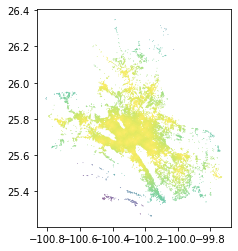

In [55]:
hex_gdf_time[np.isfinite(hex_gdf_time['distance'])].plot('distance', cmap='viridis_r')

### Nearest centrality to route

In [56]:
shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]

<ipython-input-56-9b6fb63b5e2e>:1: RuntimeWarning: Couldn't reach some vertices at /project/vendor/source/igraph/src/structural_properties.c:4726
  shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]


In [57]:
routes_osmid = [[keys_list[shortest_path_nodes[x][0][i]] for i in range(len(shortest_path_nodes[x][0]))] for x in range(len(shortest_path_nodes))]
len(routes_osmid)

15150

In [58]:
edges_G = ox.graph_to_gdfs(G, nodes=False).reset_index().set_index(['u', 'v']).sort_index()

In [59]:
i = 0

lines = []

for r in range(len(routes_osmid)):
    route_pairwise = zip(routes_osmid[r][:-1], routes_osmid[r][1:])
    
    for z in route_pairwise:
        try:
            osmid_touple = (z[0],z[1])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
        except:
            osmid_touple = (z[1],z[0])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
            
    i += 1
    if i==1 or i%1000==0 or i==(len(routes_osmid)):
        print('route',i,'finished')
        if i > 1:
            route_gdf = gpd.GeoDataFrame(lines)
            route_gdf = route_gdf.set_crs("EPSG:4326")
            #routes_join = route_gdf.rese/search?channel=fs&client=ubuntu&q=vensim+tutorialt_index().groupby(['level_0','level_1']).count()
            route_gdf.to_file(f'../data/processed/hex_route/{mun}_hex_route_cnt_t{t}_{i}.geojson', driver='GeoJSON')
            lines = []
        

route 1 finished
route 1000 finished
route 2000 finished
route 3000 finished
route 4000 finished
route 5000 finished
route 6000 finished
route 7000 finished
route 8000 finished
route 9000 finished
route 10000 finished
route 11000 finished
route 12000 finished
route 13000 finished
route 14000 finished
route 15000 finished
route 15150 finished


## Saving routes

In [192]:
route_gdf = gpd.GeoDataFrame(lines)
route_gdf = route_gdf.set_crs("EPSG:4326")
route_gdf.to_file(f'../data/processed/hex_route/AMG_hex_route_cnt_t{t}_{i}.geojson', driver='GeoJSON')
route_gdf.head(1)

,,osmid,geometry
1863387873,8763554036,831383064,"LINESTRING (-103.46913 20.54646, -103.47123 20..."


## Visualize

In [92]:
route_gdf = route_gdf.set_crs("EPSG:4326")
route_geom = route_gdf.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = route_geom.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

<AxesSubplot:>

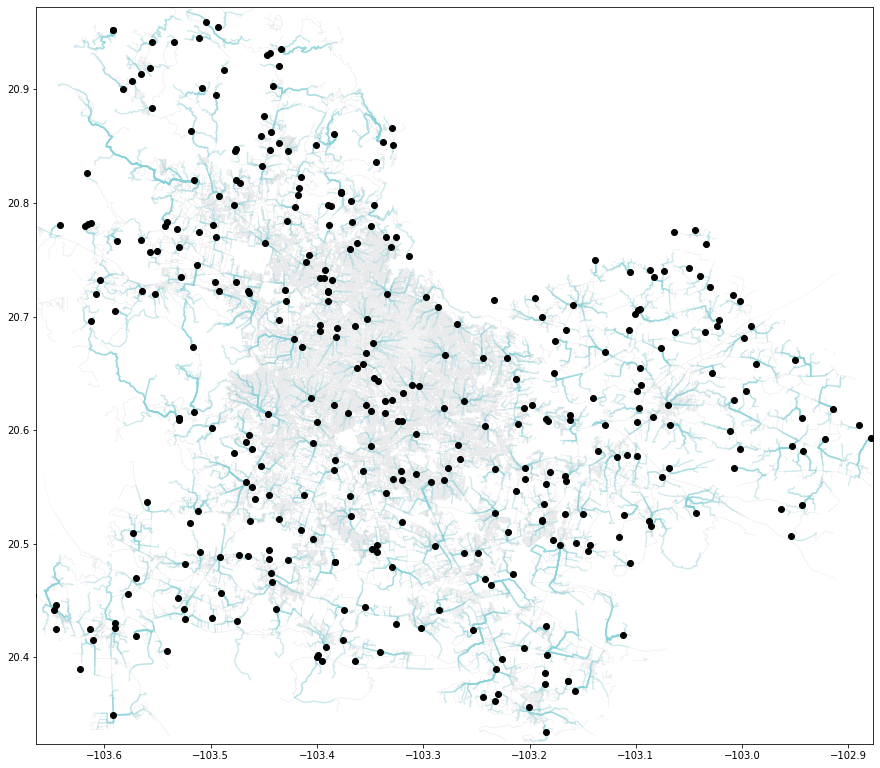

In [93]:
fig, ax = plt.subplots(figsize=(15,15))

xmin = w - 0.002
xmax = e + 0.002
ymin = s - 0.002
ymax = n + 0.002
#edges_plt = ox.graph_to_gdfs(G, nodes=False)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

centrality_nodes.plot(ax=ax, color='black', zorder=2)
edges.plot(ax=ax, color='#e8e9eb',linewidth=0.3, zorder=-1)
#edges_plt[(edges_plt['highway']=='primary') | (edges_plt['highway']=='secondary')].plot(ax=axes, color='#e8e9eb',linewidth=0.5, zorder=0)
route_gdf.plot(ax=ax, color='#86d4da', alpha=0.3, zorder=1)

In [94]:
routes_join = route_gdf.reset_index().groupby(['level_0','level_1']).count()
routes_join.head(5)

osmid  geometry
level_0  level_1                    
28777191 1610958102      2         2
28781433 6568790215      2         2
         6568790223      2         2
28781516 8366980152      1         1
28781518 8784333879      2         2

In [95]:
route_gdf.to_file(f'../data/processed/hex_route_centralities{num_cnt}.geojson', driver='GeoJSON')
centrality_nodes.to_file(f'../data/processed/centralities{num_cnt}.geojson', driver='GeoJSON')

NameError: name 'num_cnt' is not defined

## Grouping routes

### Read route files

In [60]:
gdf_routes = gpd.GeoDataFrame()
route_path = "../data/processed/hex_route/"

for f in os.listdir(route_path):
        if f.startswith(f'{mun}_hex_route_cnt_t{t}_'):
            gdf_routes = gdf_routes.append(gpd.read_file(route_path+f, driver='GeoJSON'))

#gdf_routes_all = gpd.read_file(f'../data/processed/hex_route_centralities{num_cnt}.geojson', driver='GeoJSON')
print(gdf_routes.shape)
gdf_routes.head(2)

(848977, 4)


,level_0,level_1,osmid,geometry
0,8073509098,7245288773,866168175,"LINESTRING (-100.21013 25.77055, -100.21003 25..."
1,7245288773,7245288771,776541553,"LINESTRING (-100.21003 25.77041, -100.20968 25..."


### Group routes

#### Group by geometries

In [30]:
gdf_routes['wkt'] = gdf_routes.geometry.to_wkt()
gdf_routes.head(2)

,level_0,level_1,osmid,geometry,wkt
0,6848659075,6968028960,731187785,"LINESTRING (-100.12291 25.63415, -100.12253 25...","LINESTRING (-100.123 25.6342, -100.123 25.6337)"
1,6968028960,6968028961,731187782,"LINESTRING (-100.12253 25.63366, -100.12258 25...","LINESTRING (-100.123 25.6337, -100.123 25.6336)"


In [16]:
gdf_diss = gdf_routes.groupby(['wkt']).count()
gdf_diss.rename(columns={'osmid':'count'}, inplace=True)
gdf_diss.drop(columns=['geometry','level_0','level_1'], inplace=True)
print(gdf_diss.shape)
gdf_diss.head(2)

(66380, 1)


,count
wkt,
"LINESTRING (-102.877 20.5923, -102.877 20.5924, -102.877 20.5928, -102.877 20.593, -102.877 20.593, -102.877 20.593, -102.878 20.5932, -102.879 20.5932)",1
"LINESTRING (-102.879 20.5924, -102.879 20.5923, -102.88 20.5921, -102.881 20.5914, -102.882 20.5911, -102.883 20.5903)",2


In [27]:
gdf_routes_diss = pd.merge(gdf_diss.reset_index(), gdf_routes, left_on=['wkt'],
                right_on=['wkt'], how='left')
gdf_routes_diss.drop_duplicates(inplace=True)
print(gdf_routes_diss.shape)
gdf_routes_diss.head(2)

(67348, 6)


,wkt,count,level_0,level_1,osmid,geometry
0,"LINESTRING (-102.877 20.5923, -102.877 20.5924...",1,6818422249,6818422242,727600426,"LINESTRING (-102.87685 20.59227, -102.87706 20..."
1,"LINESTRING (-102.879 20.5924, -102.879 20.5923...",2,6027655742,6027655739,639740099,"LINESTRING (-102.87928 20.59243, -102.87944 20..."


In [28]:
gdf_routes_diss['count'].sum()

1267364

#### Group by osmid [from, to]

In [61]:
gdf_diss = gdf_routes.groupby(['level_0','level_1']).count()
gdf_diss.reset_index(inplace=True)
gdf_diss.rename(columns={'osmid':'count'}, inplace=True)
gdf_diss.drop(columns=['geometry'], inplace=True)
print(gdf_diss.shape)
gdf_diss.head(5)

(82884, 3)


,level_0,level_1,count
0,269701905,7498946793,2
1,289739626,928645067,10
2,289742775,344347474,12
3,289743408,344922827,1
4,289743413,8637032816,2


In [62]:
gdf_routes_diss = gdf_diss.reset_index().merge(gdf_routes, left_on=['level_0','level_1'],
                right_on=['level_0','level_1'], how='left')
gdf_routes_diss.drop_duplicates(inplace=True)
#gdf_routes_diss.drop(columns=['wkt_x','wkt_y'], inplace=True)
print(gdf_routes_diss.shape)
gdf_routes_diss.head(2)

(82884, 6)


,index,level_0,level_1,count,osmid,geometry
0,0,269701905,7498946793,2,429103763,"LINESTRING (-100.25507 25.72857, -100.25580 25..."
2,1,289739626,928645067,10,330267437,"LINESTRING (-100.35753 25.70894, -100.35765 25..."


In [63]:
gdf_routes_diss['count'].sum()

848977

### Save file

In [64]:
gdf_routes_diss.to_file(f'../data/processed/hex_route/{mun}_hex_diss_routes_t{t}.geojson', driver='GeoJSON')

### Visualize

In [103]:
gdf_routes_diss = gdf_routes_diss.set_crs("EPSG:4326")
route_geom = gdf_routes_diss.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = route_geom.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

<AxesSubplot:>

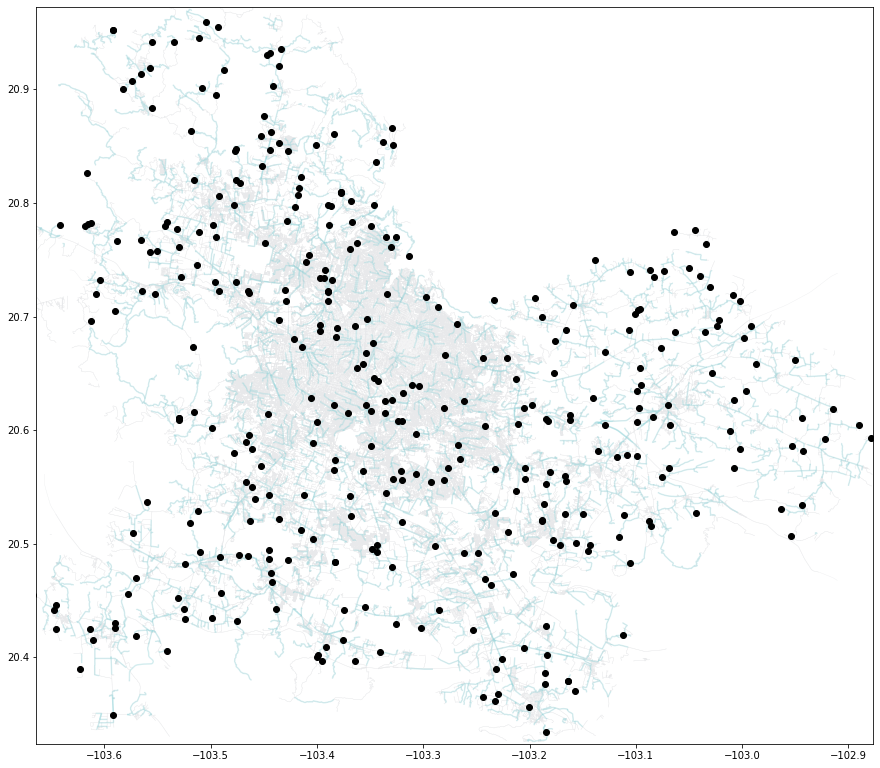

In [104]:
fig, ax = plt.subplots(figsize=(15,15))

xmin = w - 0.002
xmax = e + 0.002
ymin = s - 0.002
ymax = n + 0.002
#edges_plt = ox.graph_to_gdfs(G, nodes=False)

ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

centrality_nodes.plot(ax=ax, color='black', zorder=2)
edges.plot(ax=ax, color='#e8e9eb',linewidth=0.3, zorder=-1)
#edges_plt[(edges_plt['highway']=='primary') | (edges_plt['highway']=='secondary')].plot(ax=axes, color='#e8e9eb',linewidth=0.5, zorder=0)
gdf_routes_diss.plot(ax=ax, color='#86d4da', alpha=0.3, zorder=1)

In [34]:
gdf_routes_diss['count'].sum()

2155048